**Dataset**: https://www.nature.com/articles/s41597-024-03237-9

**Encoder and Decoder Reference**: https://www.youtube.com/watch?v=U0s0f995w14

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Import Data

In [103]:
df_train = pd.read_csv('df_train_1k.csv')
df_test = pd.read_csv('df_test_1k.csv')

## Batching

In [3]:
# Group data by uid
grouped_data_train = [group for _, group in df_train.groupby('uid')]
grouped_data_test = [group for _, group in df_test.groupby('uid')]

# Plot step data
# plt.plot(grouped_data_train[2]['t'],grouped_data_train[2]['combined_xy'])
# plt.plot(grouped_data_train[2]['t'][:100],grouped_data_train[2]['combined_xy'][:100])

In [4]:
STEP_SIZE = 100
WINDOW_SIZE = 10

In [5]:
# def generate_sequences(data, data_t):
#     return torch.tensor(data[:STEP_SIZE]),torch.tensor(data[STEP_SIZE]),\
#                 torch.tensor(data_t[:STEP_SIZE]),torch.tensor(data_t[STEP_SIZE])
# class TrajectoryDataset(Dataset):
#     def __init__(self, grouped_data):
#         self.data = grouped_data
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, idx):
#         data_for_uid = self.data[idx]
#         inputs, labels, positions, label_positions = generate_sequences(
#                                                          data_for_uid['combined_xy'].values.tolist(),
#                                                          data_for_uid['t'].values.tolist())
#         return inputs, labels, positions, label_positions
# train_dataset = TrajectoryDataset(grouped_data_train)
# test_dataset = TrajectoryDataset(grouped_data_test)

class TrajectoryDataset(Dataset):
    def __init__(self, grouped_data):
        self.data = []
        for group in grouped_data:
            if len(group) >= STEP_SIZE:
                # get the first STEP_SIZE location and time data
                xy = group['combined_xy'].values.tolist()[:STEP_SIZE]
                t = group['t'].values.tolist()[:STEP_SIZE]
                # slice the data into several sessions using moving window approach
                self.data.extend([(xy[i:i+WINDOW_SIZE], t[i:i+WINDOW_SIZE])
                                  for i in range(STEP_SIZE - WINDOW_SIZE + 1)])
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        xy_window, t_window = self.data[idx]
        inputs = torch.tensor(xy_window[:-1]) # input sequence of locations
        labels = torch.tensor(xy_window[-1]) # desired predicted location
        positions = torch.tensor(t_window[:-1]) # corresponding input locations' times
        label_positions = torch.tensor(t_window[-1]) # corresponding predicted location's time
        return inputs, labels, positions, label_positions

train_dataset = TrajectoryDataset(grouped_data_train) 
test_dataset = TrajectoryDataset(grouped_data_test)

In [6]:
def collate_fn(batch):
    # Unzip all batch
    inputs_batch, labels_batch, positions_batch, label_positions_batch = zip(*batch)
    
    # Pad the sequence with less length in a batch
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs_batch, padding_value=0.0, batch_first=True) 
    labels_padded = torch.tensor(np.array(labels_batch))
    positions_padded = torch.nn.utils.rnn.pad_sequence(positions_batch, padding_value=0, batch_first=True) 
    label_positions_padded = torch.tensor(np.array(label_positions_batch))
    
    return inputs_padded, labels_padded, positions_padded, label_positions_padded

In [7]:
BATCH_SIZE = (len(train_dataset) // len(grouped_data_train)) * 10

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# Transformer

## Input Embedding and Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data

In [9]:
# Time - Positional Encoding = Time Embedding + Sequential Encoding

class PositionalEncoding(nn.Module):
    
    def __init__(self, max_len, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 0, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(1)].squeeze(1)
        return self.dropout(x)

## Self-Attention

In [10]:
NUM_HEADS = 8

In [11]:
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate):
        super(MultiHeadAttentionModule, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None, need_weights=True):
        # Transpose from [batch size, seq length, embed dim] to [seq length, batch size, embed dim]
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)
        
        # Apply multihead attention
        attn_output, attn_output_weights = self.multihead_attn(query, key, value, attn_mask=attn_mask)
        attn_output = self.dropout(attn_output)
        return attn_output.transpose(0, 1)

## Transformer Block

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion, dropout_rate):
        super(TransformerBlock, self).__init__()
        
        # Attention Layer
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads, dropout_rate)
        
        # Normalization 1 
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Feed-Forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim), 
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim)
        )
        
        # Normalization 2
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, query, key, value):
        attn_output = self.attention(query, key, value)
        x = self.norm1(attn_output + query)
        forward = self.feed_forward(x)
        out = self.norm2(self.dropout(forward + x))
        return out

# Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, device, 
                 forward_expansion, dropout_rate):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        
        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion,
                dropout_rate=dropout_rate
            ) for _ in range(num_layers)
        ])
        
    def forward(self, inputs, positions):
        # Input Embedding
        space = self.input_embedding(inputs)

        # Positional Encoding
        positions = self.position_embedding(positions) 
        time = self.positional_encoding(positions)
        
        # Addition
        out = space + time

        # Transformer Block = Multi-Head Attention + Norm + Feed Forward + Norm
        for layer in self.layers:
            out = layer(out, out, out)
        return out

# Decoder

In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion, device, dropout_rate): 
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads, dropout_rate)
        self.norm = nn.LayerNorm(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, forward_expansion, dropout_rate)
        
    def forward(self, x, key, value, attn_mask=None):
        attention = self.attention(x,key,value,attn_mask) 
        query = self.norm(attention + x)
        out = self.transformer_block(query, key, value)
        
        return out

In [15]:
class Decoder(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, 
                 device, forward_expansion, dropout_rate):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion,
                device=device,
                dropout_rate=dropout_rate
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, loc_size)
        
    def forward(self, output, output_position, enc_out):
        space = self.input_embedding(output.unsqueeze(1))
        positions = self.position_embedding(output_position.unsqueeze(1))
        time = self.positional_encoding(positions)
        out = space + time
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, attn_mask=None)
        out = self.fc_out(out)
        return out

# Transformer Training Block

In [16]:
class Transformer(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, 
                 device, forward_expansion, dropout_rate):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(loc_size, time_size, embed_dim, 
                               num_layers, num_heads, device, forward_expansion, dropout_rate)
        self.decoder = Decoder(loc_size, time_size, embed_dim, 
                               num_layers, num_heads, device, forward_expansion, dropout_rate)
        self.device = device
    
    def forward(self, src_seq, src_pos, trg_seq, trg_pos):
        # Encode Source
        enc_out = self.encoder(src_seq, src_pos)
        # Decode target
        dec_out = self.decoder(trg_seq, trg_pos, enc_out)
        return dec_out

# Training

In [17]:
def train(model, dataloader, device, learning_rate):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for inputs, labels, positions, label_positions in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        positions, label_positions = positions.to(device), label_positions.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, positions, labels, label_positions)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(2)  # Get the index of the max log-probability
        total_correct += (predicted.squeeze() == labels).sum().item()
        total_samples += labels.numel()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    
    return avg_loss, accuracy

In [18]:
def train_model(model, dataloader, device, epochs, learning_rate):
    for epoch in range(epochs):
        avg_loss, accuracy = train(model, dataloader, device, learning_rate)
        print(f"Epoch {epoch}, Average Loss: {avg_loss}, Accuracy: {accuracy}")

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH_NUM = 2
transformer = Transformer(loc_size=40000, 
                          time_size=48,
                          embed_dim=256,
                          num_layers=1,
                          num_heads=8,
                          device=device,
                          forward_expansion=4,
                          dropout_rate=0.1)
transformer.to(device)
train_model(transformer, train_dataloader, device, epochs=EPOCH_NUM, learning_rate=0.0013)

""" 10k
Epoch 0, Average Loss: 1.5751103802556257, Accuracy: 0.863751992964745
Epoch 1, Average Loss: 0.08293261576167783, Accuracy: 0.993369415230183
"""

""" 1k
Epoch 0, Average Loss: 7.268777912855148, Accuracy: 0.27751044438622857
Epoch 1, Average Loss: 2.5327855929732324, Accuracy: 0.7864657300039986
"""

# Inference

In [20]:
import torch.nn.functional as F

In [21]:
def evaluate_model_with_top_k(model, dataloader, device, k):
    model.eval()
    total_correct = 0
    total_examples = 0
    
    with torch.no_grad():
        for inputs, labels, positions, label_positions in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            positions = positions.to(device)
            label_positions = label_positions.to(device)
            
            logits = model(inputs, positions, labels, label_positions)
            
            if (BATCH_SIZE > 1):
                for logit_i in range(len(logits)):
                    tolerated_acc = int(labels[logit_i] in torch.topk(logits[logit_i], k)[1])
                    total_correct += tolerated_acc
            else:
                tolerated_acc = int(labels in torch.topk(logits, k)[1])
                total_correct += tolerated_acc
            
            total_examples += labels.numel()
    
    print(f"Batch Size: {BATCH_SIZE} Top {k} Accuracy: {total_correct/total_examples}, Num Correct: {total_correct}, Num Sample: {total_examples}")
    
    return total_correct/total_examples

In [24]:
transformer_accuracy = evaluate_model_with_top_k(transformer, test_dataloader, device, 1)

""" 10k
Batch Size: 910 Top 5 Accuracy: 0.9818553539483772, Num Correct: 176732, Num Sample: 179998
"""

""" 1k
Batch Size: 910 Top 1 Accuracy: 0.5997802197802198, Num Correct: 10916, Num Sample: 18200
"""

# Visualization

In [91]:
frequent_locations = [(152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (178, 34), (125, 137), (158, 64), (125, 137), (152, 95), (130, 63), (129, 81), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (152, 95), (152, 95), (152, 95)]

In [127]:
# extract correct or incorrect prediction for visualization
def extract_prediction(model, dataloader, device, k, extract_correct=True):
    model.eval()
    with torch.no_grad():
        for inputs, labels, positions, label_positions in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            positions = positions.to(device)
            label_positions = label_positions.to(device)
            
            logits = model(inputs, positions, labels, label_positions)
            
            for logit_i in range(len(logits)):
                if (extract_correct):
                    if (int(labels[logit_i] in torch.topk(logits[logit_i], k)[1])):
                        return inputs[logit_i].tolist(), \
                                labels[logit_i].item(), \
                                positions[logit_i].tolist(), \
                                label_positions[logit_i].item(), \
                                torch.topk(logits[logit_i], k)[1].item()
                else:
                    if (int(labels[logit_i] not in torch.topk(logits[logit_i], k)[1])):
                        return inputs[logit_i].tolist(), \
                                labels[logit_i].item(), \
                                positions[logit_i].tolist(), \
                                label_positions[logit_i].item(), \
                                torch.topk(logits[logit_i], k)[1].item()

In [126]:
def plot_trajectory(inputs, labels, positions, label_positions, prediction, display_frequent=True): 
    """
    inputs: List<int>: trajctory of a user; a list of location-id a user has stepped through
    labels: int: the desired location-id or the label of the model prediction
    positions: List<int>: corresponding time recorded in each of the trajectory data above
    label_positions: int: corresponding time of the recorded label location-id
    prediction: int: the predicted location-id made by the model
    display_frequent: boolean: whether or not to display the most frequently visited location
    """
    
    # Determine if the prediction is correct
    false_prediction = True
    if (prediction == labels): 
        false_prediction = False
        
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Plot the trajectory (blue line)
    inputs = df_train[df_train['combined_xy'].isin(inputs)] # def
    ys = list(inputs['y'])
    xs = list(inputs['x'])
    ax.plot(xs, ys, label='Trajectory', linewidth=0.5)
    ax.scatter(xs, ys)
    
    # # Trajectory Time Annotation
    # for i in range(len(positions)):
        # ax.annotate(str(positions[i]), (inputs.iloc[i]['x'], inputs.iloc[i]['y']), 
        # textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot label (green dot)
    df_train_labels = df_train[df_train['combined_xy']==labels].iloc[0] # def
    labels = (df_train_labels['x'], df_train_labels['y'])
    ax.plot(*labels,'go', label='Actual Location') 
    
    # # Label Time Annotation
    # ax.annotate(str(label_positions), labels, textcoords="offset points", 
    # xytext=(0,10), ha='center')

    # If false prediction: plot predicted location (red dot)
    if false_prediction:
        df_train_prediction = df_train[df_train['combined_xy']==prediction].iloc[0] # def
        prediction = (df_train_prediction['x'], df_train_prediction['y'])
        ax.plot(*prediction, 'ro', label='Predicted Location')
    
    # If request display_requent: plot frequently visited location (purple dot)
    if display_frequent:
        frequent = frequent_locations[label_positions]
        ax.plot(*frequent, 'mo', label='Frequent Location')
    
    # # Setting up the legend and labels
    # ax.set_xlim(0, 200)
    # ax.set_ylim(0, 200)
    # ax.set_xticks(range(0, 201, 1))
    # ax.set_yticks(range(0, 201, 1))
    ax.grid(True)
    ax.set_xlabel('X-Coordinate')
    ax.set_ylabel('Y-Coordinate')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

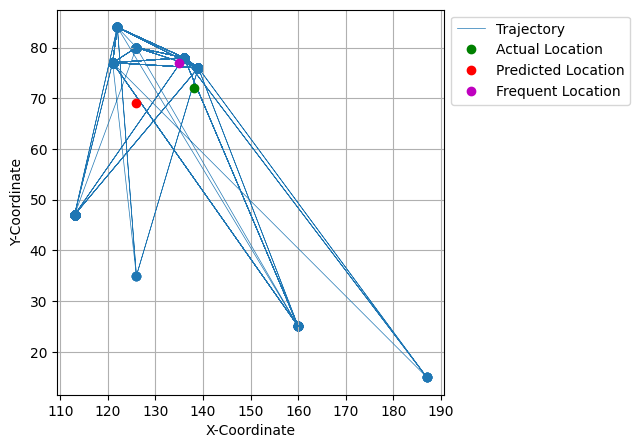

In [125]:
inputs,labels,positions,label_positions,prediction = extract_prediction(transformer,test_dataloader,device,1,False)
plot_trajectory(inputs,labels,positions,label_positions,prediction)

# Hyperparameter-Tuning

In [ ]:
import optuna

In [ ]:
batch_sizes = [int(i) for i in range(5,101,5)]
batch_sizes.append(1)
batch_sizes = sorted(batch_sizes)

In [ ]:
def objective(trial):
    
    # Set up dataloader
    batch_size = trial.suggest_categorical('batch_size', batch_sizes)  ##
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # Model Parameter
    loc_size = 40000
    time_size = 600
    embed_dim = 256
    # embed_dim = trial.suggest_categorical('embed_dim', [64, 128, 256, 512])
    # num_layers = 1
    num_layers = trial.suggest_int('num_layers', 1, 6)  ##
    num_heads = 8
    # num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    forward_expansion = 4
    # forward_expansion = trial.suggest_categorical('forward_expansion', [1, 2, 4])
    dropout_rate = 0.1
    
    # Model
    transformer = Transformer(loc_size=loc_size,
                              time_size=time_size,
                              embed_dim=embed_dim,
                              num_layers=num_layers,
                              num_heads=num_heads,
                              device=device,
                              forward_expansion=forward_expansion,
                              dropout_rate=dropout_rate)
    transformer.to(device)
    
    # Train the model
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1) 
    
    # Training loop
    total_loss = 0
    for epoch in range(5):
        avg_loss, accuracy = train(transformer, train_dataloader, device, learning_rate)
        total_loss += avg_loss
    final_avg_loss = total_loss/10
    
    return final_avg_loss

In [ ]:
# Hyperparameter tuning

# Create a study object and optimize the objective function
study = optuna.create_study()
study.optimize(objective, n_trials=50)

# Result
print('Best parameters:', study.best_params)
print('Best loss:', study.best_value)